**TDS final project**

## Pre-process of datasets and imports

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score,  precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import shap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

In [5]:
#Data set 1:
df1 = pd.read_csv("data/bank-full.csv")
df1 = df1.dropna()  # Drop rows with missing values
categorical_cols = df1.select_dtypes(include=['object', 'category']).columns
df1 = pd.get_dummies(df1, columns=categorical_cols, drop_first=True)
X_bank = df1[[col for col in df1.columns if col != 'y_yes']]
y_bank = df1['y_yes']

In [6]:
#Data set 2:
df2 = pd.read_csv("data/use_stroke_dataset.csv")
df2 = df2.dropna()  # Drop rows with missing values
categorical_cols = df2.select_dtypes(include=['object', 'category']).columns
df2 = pd.get_dummies(df2, columns=categorical_cols, drop_first=True)
X_stroke = df2[[col for col in df2.columns if col != 'stroke']]
y_stroke = df2['stroke']

In [7]:
#Data set 3:

df = pd.read_csv("data/Student_performance_data _.csv")
df = df.dropna()  # Drop rows with missing values
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df = df.drop(columns=["GPA", "StudentID"])
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.iloc[:, -1] = (df.iloc[:, -1] != 0).astype(int)
X_students = df[[col for col in df.columns if col != 'GradeClass']]
y_students = df['GradeClass']

In [8]:
#Data set 4:

df4 = pd.read_csv("data/WineQT.csv")
df4 = df4.dropna()  # Drop rows with missing values
categorical_cols = df4.select_dtypes(include=['object', 'category']).columns
df4 = df4.drop(columns=["Id"])
df4["quality"] = df4["quality"].apply(lambda x: 1 if x in [7, 8] else 0)
df4 = pd.get_dummies(df4, columns=categorical_cols, drop_first=True)
X_wine = df4[[col for col in df4.columns if col != 'quality']]
y_wine = df4['quality']

## Basic model

In [9]:

def train_and_evaluate(X_train, X_test, y_train, y_test, show=False):
    """
    Trains an XGBoost classifier, evaluates its performance, and returns metrics.

    Parameters:
        X_train (pd.DataFrame or np.ndarray): Training feature matrix.
        X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
        y_train (pd.Series or np.ndarray): Training target labels.
        y_test (pd.Series or np.ndarray): Testing target labels.
        show (bool): If True, prints the accuracy and balanced accuracy (default: False).

    Returns:
        dict: Dictionary containing accuracy, balanced accuracy, and the trained model.
    """

    # Train XGBoost model
    model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    if show:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return {"accuracy": accuracy, "balanced_accuracy": balanced_acc, "model": model}



## Problem statment - imbalanced classes

Although the overall accuracy is high, the balanced accuracy remains low due to the imbalance in the data. This suggests that the model is performing well on the majority class but struggling to accurately classify the minority class.

In [10]:

def plot_class_distribution_with_accuracy(y_tests, y_preds, y_preds_improved, dataset_names):
    """
    Plots class distributions as percentages with classification accuracy marked inside the bars
    for both the original and improved models.

    Parameters:
        y_tests (list of arrays): List of true labels for each dataset.
        y_preds (list of arrays): List of predicted labels for each dataset (original model).
        y_preds_improved (list of arrays): List of predicted labels for the improved model.
        dataset_names (list of str): List of dataset names.
    """
    num_datasets = len(y_tests)
    colors = plt.get_cmap("tab10", num_datasets).colors  # Dynamically get colors

    plt.figure(figsize=(10, 6))
    bar_width = 0.8 / num_datasets  # Adjust bar width based on dataset count

    for i, (y_test, y_pred, y_pred_improved, name) in enumerate(zip(y_tests, y_preds, y_preds_improved, dataset_names)):
        class_counts = Counter(y_test)
        correct_counts = Counter(y_test[y_test == y_pred])
        correct_counts_improved = Counter(y_test[y_test == y_pred_improved])

        labels = sorted(class_counts.keys())
        total_counts = np.array([class_counts[label] for label in labels])
        correct_counts_list = np.array([correct_counts.get(label, 0) for label in labels])
        correct_counts_list_improved = np.array([correct_counts_improved.get(label, 0) for label in labels])

        class_percentages = total_counts / total_counts.sum() * 100  # Convert to percentage
        correct_percentages = correct_counts_list / total_counts * 100  # Accuracy (original)
        correct_percentages_improved = correct_counts_list_improved / total_counts * 100  # Accuracy (improved)

        x_positions = np.arange(len(labels)) + (i * bar_width)

        bars = plt.bar(x_positions, class_percentages, color=colors[i], edgecolor='black',
                       width=bar_width, label=name)

        # Add accuracy stripes for both models inside the bars
        for x, bar_height, acc_orig, acc_improved in zip(x_positions, class_percentages, correct_percentages, correct_percentages_improved):
            # Original model stripe (Black) - relative to percentage scale
            plt.hlines(acc_orig, x - bar_width / 2, x + bar_width / 2, colors='black', linewidth=2)

            # Improved model stripe (green) - relative to percentage scale
            plt.hlines(acc_improved, x - bar_width / 2, x + bar_width / 2, colors='green', linewidth=2)

    plt.xlabel("Class Label")
    plt.ylabel("Percentage of Dataset")
    plt.title("Class Distribution with Accuracy Stripes (Original = Black, Improved = Green)")
    plt.xticks(np.arange(len(labels)) + (bar_width * (num_datasets - 1) / 2), labels)
    plt.legend()
    plt.show()


## Our method

In [11]:

def balances_data(X_train, y_train, balancing_hyperparameter=3, threshold=0.3, show=False):
    """
    Balances the training data using KMeans clustering for undersampling the majority class.

    Parameters:
        X_train (pd.DataFrame): Training feature matrix.
        y_train (pd.Series): Training target labels.
        balancing_hyperparameter (int): Multiplier for the number of clusters in KMeans (default: 3).
        threshold (float): Imbalance ratio threshold below which undersampling is applied (default: 0.3).

    Returns:
        tuple: Balanced training feature matrix and target labels.
    """
    # Splitting training data based on class labels
    X_train_0 = X_train.loc[y_train == 0]
    X_train_1 = X_train.loc[y_train == 1]

    # Identifying majority and minority class
    X_majority = X_train_0 if len(X_train_0) > len(X_train_1) else X_train_1
    X_minority = X_train_1 if len(X_train_1) < len(X_train_0) else X_train_0

    # Checking class imbalance ratio
    imbalance_ratio = len(X_minority) / (len(X_minority) + len(X_majority))
    if show:
      print(f"Class imbalance ratio: {imbalance_ratio:.4f}")

    if imbalance_ratio < threshold:
        # Convert to numeric and fill NaN values
        X_majority_numeric = X_majority.apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()

        # Applying KMeans to cluster the majority class
        kmeans = KMeans(n_clusters=balancing_hyperparameter * len(X_minority))
        kmeans.fit(X_majority_numeric)

        # Predict cluster labels for majority class samples
        cluster_labels = kmeans.predict(X_majority_numeric)

        # Initialize an array for cluster centers using majority vote instead of mean
        X_majority_clustered = np.zeros((balancing_hyperparameter * len(X_minority), X_majority.shape[1]))

        # Compute the most frequent value for each feature in each cluster, only for columns with exactly 2 unique values
        for cluster_idx in range(len(X_majority_clustered)):
            cluster_points = X_majority_numeric[cluster_labels == cluster_idx]  # Get points assigned to this cluster
            if len(cluster_points) > 0:
                for col_idx in range(X_majority_numeric.shape[1]):
                    values, counts = np.unique(cluster_points[:, col_idx], return_counts=True)  # Get unique values and their counts
                    if len(values) == 2:  # Only apply if there are exactly 2 unique values
                        X_majority_clustered[cluster_idx, col_idx] = values[np.argmax(counts)]  # Select the most frequent value
                    else:
                        X_majority_clustered[cluster_idx, col_idx] = np.mean(cluster_points[:, col_idx])  # Use mean for non-binary columns

        # Convert back to DataFrame
        X_majority_clustered = pd.DataFrame(X_majority_clustered, columns=X_train.columns)
        # Stack the new majority class (clustered) with the minority class
        X_train_balanced = np.vstack((X_majority_clustered, X_minority.to_numpy()))
        # Create balanced labels
        if len(X_train_0) > len(X_train_1):
            y_train_balanced = np.hstack((np.zeros(len(X_majority_clustered)), np.ones(len(X_minority))))
        else:
            y_train_balanced = np.hstack((np.ones(len(X_majority_clustered)), np.zeros(len(X_minority))))

        # Convert to DataFrame with correct dtypes
        X_train_b = pd.DataFrame(X_train_balanced, columns=X_train.columns).astype(X_train.dtypes.to_dict())
        y_train_b = pd.Series(y_train_balanced)
        if show:
          print(f"Balanced training set: Majority class = {len(X_majority_clustered)}, Minority class = {len(X_minority)}")
    return X_train_b, y_train_b


In [12]:
def pca_plot(X_train, X_train_b, y_train, y_train_balanced, dataset_name, ax):
    """
    Creates a 3D PCA plot comparing original and balanced training data.

    Parameters:
        X_train (pd.DataFrame or np.ndarray): Original training feature matrix.
        X_train_b (pd.DataFrame or np.ndarray): Balanced training feature matrix.
        y_train (pd.Series or np.ndarray): Original training target labels.
        y_train_balanced (pd.Series or np.ndarray): Balanced training target labels.
        ax (matplotlib.axes._axes.Axes): Axes to plot the graph on.
        dataset_name (str): Name of the dataset for title.

    Returns:
        None: Displays a 3D scatter plot.
    """
    # Applying PCA to reduce data to 3 dimensions
    pca = PCA(n_components=3)
    X_pca_original = pca.fit_transform(X_train)  # Transform original data
    X_pca_balanced = pca.transform(X_train_b)  # Transform balanced data

    # Determine which class is larger in the original and balanced data
    class_0_original = (y_train == 0).sum()
    class_1_original = (y_train == 1).sum()
    class_0_balanced = (y_train_balanced == 0).sum()
    class_1_balanced = (y_train_balanced == 1).sum()

    # Choose the larger class in the original and balanced datasets
    larger_class_original = 0 if class_0_original > class_1_original else 1
    larger_class_balanced = 0 if class_0_balanced > class_1_balanced else 1

    # Create masks for the larger class
    mask_original = (y_train == larger_class_original)
    mask_balanced = (y_train_balanced == larger_class_balanced)

    # Create scatter plot for original data (larger class)
    ax.scatter(X_pca_original[mask_original, 0], X_pca_original[mask_original, 1], X_pca_original[mask_original, 2],
               c='red', alpha=0.1, label=f"Original Data (Class {larger_class_original})")
    # Scatter plot for balanced data (larger class)
    ax.scatter(X_pca_balanced[mask_balanced, 0], X_pca_balanced[mask_balanced, 1], X_pca_balanced[mask_balanced, 2],
               c='blue', alpha=0.1, label=f"Balanced Data (Class {larger_class_balanced})")

    # Set labels and title
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3", labelpad=-1)
    ax.set_title(f"3D PCA Plot: {dataset_name}")
    ax.view_init(elev=50, azim=30)
    ax.legend()
    plt.tight_layout()


In [13]:

def evaluate_models(model, model_b, X_test, y_test):
  """
  Evaluates two models on the test data and returns various performance metrics.

  Parameters:
      model (xgb.XGBClassifier): The baseline XGBoost model.
      model_b (xgb.XGBClassifier): The balanced XGBoost model (using KMeans).
      X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
      y_test (pd.Series or np.ndarray): Testing target labels.

  Returns:
      dict: Dictionary containing performance metrics for both models.
  """
  # Predict
  y_pred = model.predict(X_test)
  y_pred_b = model_b.predict(X_test)
  # Compute metrics
  metrics = {
      "Baseline XGBoost": {
          "Acc": accuracy_score(y_test, y_pred),
          "Bal Acc": balanced_accuracy_score(y_test, y_pred),
          "Prec": precision_score(y_test, y_pred, average='binary'),
          "Recall": recall_score(y_test, y_pred, average='binary'),
          "F1 Score": f1_score(y_test, y_pred, average='binary')

      },
      "Our Balanced": {
          "Acc": accuracy_score(y_test, y_pred_b),
          "Bal Acc": balanced_accuracy_score(y_test, y_pred_b),
          "Prec": precision_score(y_test, y_pred_b, average='binary'),
          "Recall": recall_score(y_test, y_pred_b, average='binary'),
          "F1 Score": f1_score(y_test, y_pred_b, average='binary')

      }
  }

  return metrics


## Compare to existing baselines

In [14]:
def compare_to_existing_baselines(X_train, y_train, X_test, y_test, metrics, show=False):
  """
  Compares the performance of models trained on different balanced datasets to existing baselines.

  Parameters:
      X_train (pd.DataFrame or np.ndarray): Training feature matrix.
      y_train (pd.Series or np.ndarray): Training target labels.
      X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
      y_test (pd.Series or np.ndarray): Testing target labels.
      metrics (dict): Dictionary to update with new metrics.
      show (bool): If True, prints the metrics DataFrame (default: False).

  Returns:
      pd.DataFrame: DataFrame containing performance metrics for all models.
  """
  # Apply Random Undersampling
  rus = RandomUnderSampler(random_state=42)
  X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

  # Apply SMOTE (Synthetic Minority Over-sampling)
  smote = SMOTE(random_state=42)
  X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


  # Train models on each balanced dataset
  model_rus = xgb.XGBClassifier(eval_metric='logloss')
  model_rus.fit(X_train_rus, y_train_rus)
  y_pred_rus = model_rus.predict(X_test)

  model_smote = xgb.XGBClassifier(eval_metric='logloss')
  model_smote.fit(X_train_smote, y_train_smote)
  y_pred_smote = model_smote.predict(X_test)

  # Compute metrics for all models
  metrics.update({
      "Random Undersampling": {
          "Acc": accuracy_score(y_test, y_pred_rus),
          "Bal Acc": balanced_accuracy_score(y_test, y_pred_rus),
          "Prec": precision_score(y_test, y_pred_rus, average='binary'),
          "Recall": recall_score(y_test, y_pred_rus, average='binary'),
          "F1 Score": f1_score(y_test, y_pred_rus, average='binary')

      },
      "SMOTE": {
          "Acc": accuracy_score(y_test, y_pred_smote),
          "Bal Acc": balanced_accuracy_score(y_test, y_pred_smote),
          "Prec": precision_score(y_test, y_pred_smote, average='binary'),
          "Recall": recall_score(y_test, y_pred_smote, average='binary'),
          "F1 Score": f1_score(y_test, y_pred_smote, average='binary')

      }
  })

  # Convert metrics into a pandas DataFrame for easy visualization
  df_metrics = pd.DataFrame(metrics).T

  # Optionally, display in the console
  if show:
    print(df_metrics)
  return df_metrics


## Run on all datasets

In [ ]:

def evaluate_and_plot_multiple_datasets(X_list, y_list, dataset_names, balancing_params):
    """
    Evaluates models on multiple datasets, balances the data, and plots the results.

    Parameters:
        X_list (list): List of feature matrices for datasets.
        y_list (list): List of target labels for datasets.
        dataset_names (list): List of dataset names.

    Returns:
        tuple: Containing training data, test data, and evaluation results.
    """
    train_data, test_data, all_results = {}, {}, {}

    for i, (X, y, name) in enumerate(zip(X_list, y_list, dataset_names)):
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train and evaluate original model
        results_original = train_and_evaluate(X_train, X_test, y_train, y_test)

        # Balance data
        X_train_bal, y_train_bal = balances_data(
            X_train, y_train, balancing_hyperparameter=balancing_params[i],
            show=True)

        # Train and evaluate balanced model
        results_balanced = train_and_evaluate(X_train_bal, X_test, y_train_bal, y_test)

        # Store results
        train_data[i] = (X_train, X_train_bal, y_train, y_train_bal, name)
        test_data[i] = (X_test, y_test)
        all_results[i] = (results_original, results_balanced)

    # Generate plots
    plot_class_distribution_with_accuracy(
        y_tests=[test_data[i][1] for i in range(len(dataset_names))],
        y_preds=[all_results[i][0]["model"].predict(test_data[i][0]) for i in range(len(dataset_names))],
        y_preds_improved=[all_results[i][1]["model"].predict(test_data[i][0]) for i in range(len(dataset_names))],
        dataset_names=dataset_names
    )

    return train_data, test_data, all_results

Class imbalance ratio: 0.1161
Balanced training set: Majority class = 12594, Minority class = 4198
Class imbalance ratio: 0.0189
Balanced training set: Majority class = 2200, Minority class = 440
Class imbalance ratio: 0.0444
Balanced training set: Majority class = 255, Minority class = 85
Class imbalance ratio: 0.1433
Balanced training set: Majority class = 393, Minority class = 131


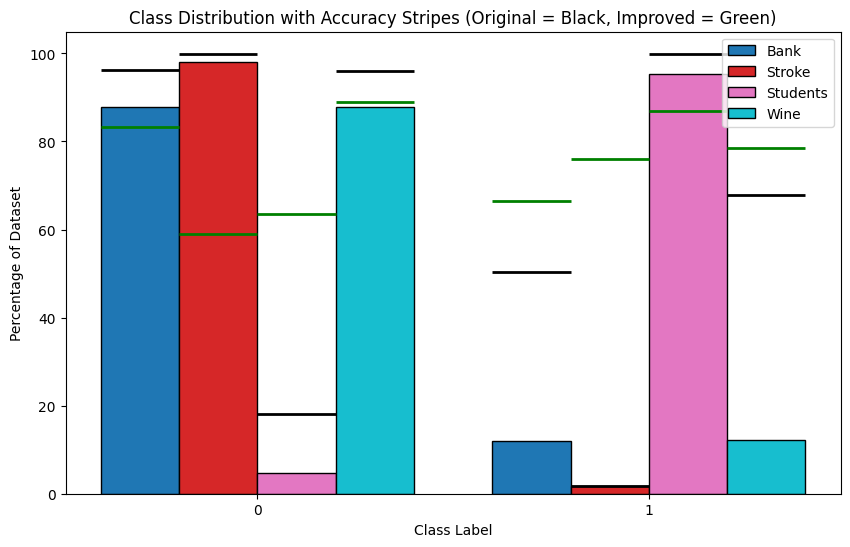

In [ ]:
dataset_names=["Bank", "Stroke", "Students", "Wine"]
X_list = [X_bank, X_stroke, X_students, X_wine]
y_list = [y_bank, y_stroke, y_students, y_wine]

balancing_params = [3, 5, 3, 3]
train_data, test_data, all_results = evaluate_and_plot_multiple_datasets(X_list, y_list, dataset_names, balancing_params)

Figure 1: Classification accuracy with (green) and without (black) our method. XGBoost on imbalanced data favors the majority class, reducing minority class performance.

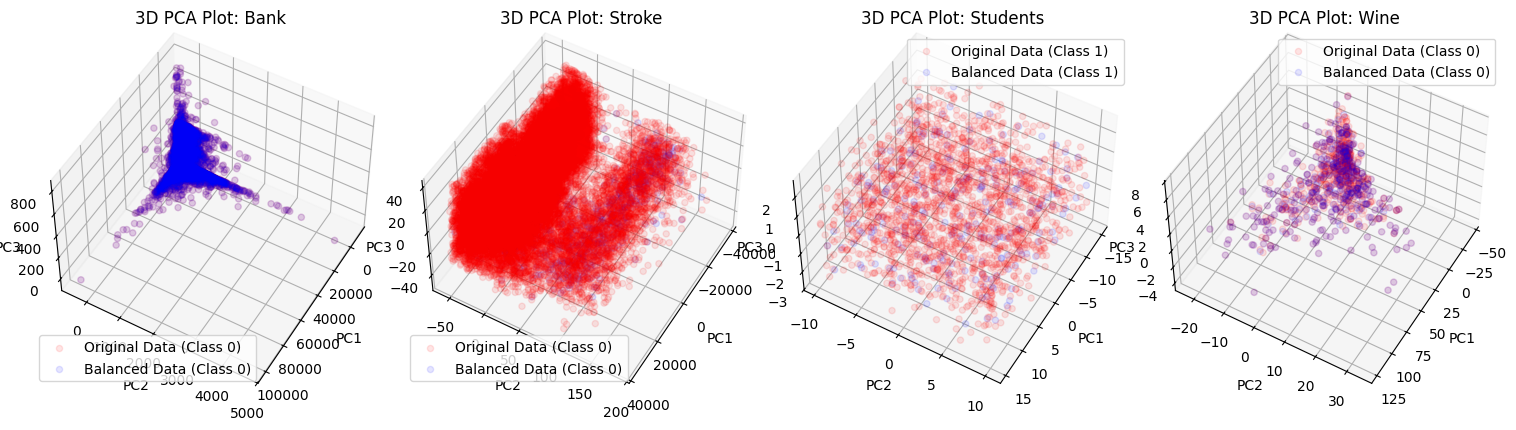

In [ ]:
# Create a figure and subplots
fig = plt.figure(figsize=(15, 12))

# Create subplots (2 rows, 2 columns)
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    pca_plot(*train_data[i], ax=ax)

plt.tight_layout()  # Adjust subplots to fit nicely in the figure
plt.show()

Figure 2: Scatterplots of four datasets after 3D PCA. Red dots represent original data points, while blue dots mark K-Means cluster centers, capturing the overall data structure.

In [ ]:
def evaluate_all(train_data, test_data, results):
  for i in range(4):
    metrics = evaluate_models(results[i][0]["model"], results[i][1]["model"], *test_data[i])
    compare_to_existing_baselines(train_data[i][0], train_data[i][2], *test_data[i], metrics, show=True)
    print()

evaluate_all(train_data, test_data, all_results)

                           Acc   Bal Acc      Prec    Recall  F1 Score
Baseline XGBoost      0.906447  0.732885  0.643275  0.504125  0.565262
Our Balanced          0.811567  0.748134  0.351430  0.664528  0.459734
Random Undersampling  0.846732  0.863820  0.433827  0.886343  0.582530
SMOTE                 0.894062  0.754313  0.559856  0.570119  0.564941

                           Acc   Bal Acc      Prec    Recall  F1 Score
Baseline XGBoost      0.981083  0.508909  0.333333  0.018519  0.035088
Our Balanced          0.593809  0.674969  0.033912  0.759259  0.064925
Random Undersampling  0.693551  0.748494  0.047078  0.805556  0.088957
SMOTE                 0.960619  0.507567  0.031008  0.037037  0.033755

                           Acc   Bal Acc      Prec    Recall  F1 Score
Baseline XGBoost      0.960334  0.589815  0.962025  0.997812  0.979592
Our Balanced          0.858038  0.752536  0.980247  0.868709  0.921114
Random Undersampling  0.768267  0.727124  0.980556  0.772429  0.864137
SMOT

## Explainability

In [ ]:
def shap_basic_improved(X_test, X_train, X_train_b, imbalanced_model, balanced_model):
  """
  Computes SHAP values for test data using models trained on original and balanced datasets.

  Parameters:
      X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
      X_train (pd.DataFrame or np.ndarray): Training feature matrix for the original model.
      X_train_b (pd.DataFrame or np.ndarray): Training feature matrix for the balanced model.
      imbalanced_model (xgb.XGBClassifier): Model trained on original data.
      balanced_model (xgb.XGBClassifier): Model trained on balanced data.

  Returns:
      tuple: SHAP values for the test data from both models.
  """
  X_test = X_test.astype(int)
  X_train = X_train.astype(int)
  X_train_b = X_train_b.astype(int)
  # Create SHAP explainer for the first model (trained on original data)
  explainer_basic = shap.Explainer(imbalanced_model, X_train)

  # Create SHAP explainer for the second model (trained on balanced data)
  explainer_balanced = shap.Explainer(balanced_model, X_train_b)

  # Compute SHAP values for test data
  shap_values_basic = explainer_basic(X_test)
  shap_values_balanced = explainer_balanced(X_test)
  return shap_values_basic, shap_values_balanced

In [ ]:
def plot_shap(shap_values_basic, shap_values_balanced, X_test, dataset_name):
  """
  Plots SHAP summary plots for models trained on original and balanced datasets.

  Parameters:
      shap_values_basic (shap.Explanation): SHAP values for the original model.
      shap_values_balanced (shap.Explanation): SHAP values for the balanced model.
      X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
      dataset_name (str): Name of the dataset for the plot titles.

  Returns:
      None: Displays SHAP summary plots.
  """
  X_test = X_test.astype(int)
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Summary plot for the original model
  plt.sca(axes[0])  # Set the first subplot as active
  shap.summary_plot(shap_values_basic, X_test, show=False)
  axes[0].set_title("Original Model " + dataset_name)

  # Summary plot for the balanced model
  plt.sca(axes[1])  # Set the second subplot as active
  shap.summary_plot(shap_values_balanced, X_test, show=False)
  axes[1].set_title("Balanced Model " + dataset_name)

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_shap_feature(X_test, shap_values_basic, shap_values_balanced, feature_to_plot, dataset_name):
  """
  Plots SHAP dependence plot for a specific feature comparing models trained on original and balanced datasets.

  Parameters:
      X_test (pd.DataFrame or np.ndarray): Testing feature matrix.
      shap_values_basic (shap.Explanation): SHAP values for the original model.
      shap_values_balanced (shap.Explanation): SHAP values for the balanced model.
      feature_to_plot (str): Name of the feature to plot.
      dataset_name (str): Name of the dataset for the plot title.

  Returns:
      None: Displays a scatter plot comparing SHAP values for the specified feature.
  """
  X_test = X_test.astype(int)
  feature_idx = X_test.columns.get_loc(feature_to_plot)  # Get index of feature

  # Extract feature values and SHAP values
  feature_values = X_test.iloc[:, feature_idx]
  shap_vals1 = shap_values_basic.values[:, feature_idx]
  shap_vals2 = shap_values_balanced.values[:, feature_idx]

  # Plot both datasets on the same plot
  plt.figure(figsize=(8, 6))
  plt.scatter(feature_values, shap_vals1, color='red', alpha=0.5, label="Original Model")
  plt.scatter(feature_values, shap_vals2, color='blue', alpha=0.5, label="Balanced Model")
  plt.xlabel(feature_to_plot)
  plt.ylabel("SHAP Value")
  plt.legend()
  plt.title(f"SHAP Dependence Plot: Feature {feature_to_plot} in " + dataset_name + " dataset")

  plt.show()


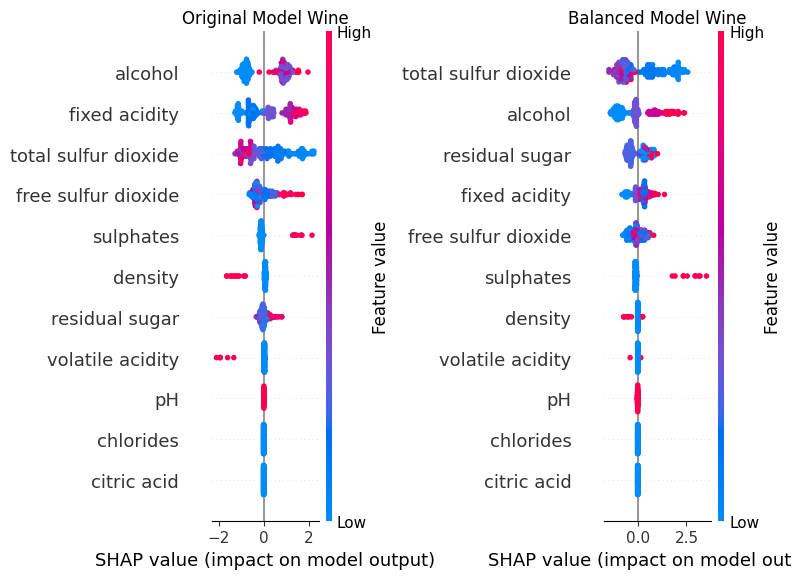

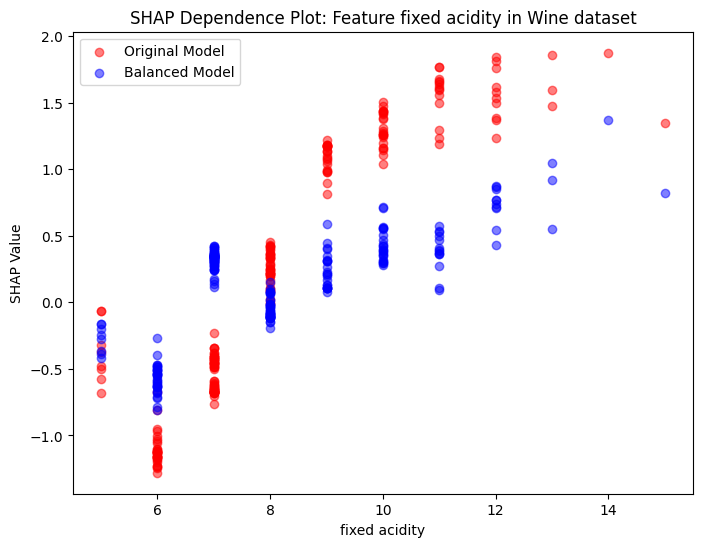

In [ ]:
shap_values_basic, shap_values_balanced = shap_basic_improved(
    test_data[3][0], train_data[3][0], train_data[3][1],
    all_results[3][0]["model"], all_results[3][1]["model"]
    )
plot_shap(shap_values_basic, shap_values_balanced, test_data[3][0], dataset_names[3])
plot_shap_feature(test_data[3][0], shap_values_basic, shap_values_balanced,
                  "fixed acidity", dataset_names[3])

Figure 3: (Top) SHAP analysis for all features in the wine quality prediction dataset. (Bottom)SHAP analysis of acidity in the wine quality prediction dataset.

For readability, we ran the analysis on only one dataset.

You can use the following code and obtain these results for all datasets:

In [ ]:
# important_features = ["month_may", "age", "Age", "fixed acidity"]
# for i in range(4):
#   shap_values_basic, shap_values_balanced = shap_basic_improved(
#       test_data[i][0], train_data[i][0], train_data[i][1],
#       all_results[i][0]["model"], all_results[i][1]["model"])
#   plot_shap(shap_values_basic, shap_values_balanced, test_data[i][0], dataset_names[i])
#   plot_shap_feature(test_data[i][0], shap_values_basic, shap_values_balanced,
#                     important_features[i], dataset_names[i])


## Statistical test

In [24]:
from scipy.stats import kstest
import scipy.stats as stats

def statistical_test(X, y, balancing_hyperparameter):
  """
  Performs a statistical test to compare the performance of models trained on original and balanced datasets.

  Parameters:
      X (pd.DataFrame or np.ndarray): Feature matrix.
      y (pd.Series or np.ndarray): Target labels.
      balancing_hyperparameter (int): Hyperparameter for balancing the data.

  Returns:
      None: Prints the p-value of the Wilcoxon signed-rank test.
  """
  # Cross-validation setup
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Store results
  accuracies_balanced = []
  accuracies_imbalanced = []

  for train_idx, test_idx in kf.split(X, y):
      X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
      y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

      # Train and evaluate original model
      results_original = train_and_evaluate(X_train, X_test, y_train, y_test)["balanced_accuracy"]
      # Balance data
      X_train_bal, y_train_bal = balances_data(X_train, y_train, balancing_hyperparameter)
      # Train and evaluate balanced model
      results_balanced = train_and_evaluate(X_train_bal, X_test, y_train_bal, y_test)["balanced_accuracy"]
      accuracies_imbalanced.append(results_original)
      accuracies_balanced.append(results_balanced)

  # Convert to NumPy arrays
  accuracies_balanced = np.array(accuracies_balanced)
  accuracies_imbalanced = np.array(accuracies_imbalanced)
  diff = accuracies_balanced - accuracies_imbalanced


  # Statistical Tests
  _, p_wilcoxon = wilcoxon(accuracies_balanced, accuracies_imbalanced, alternative='greater')
  print(f"Wilcoxon signed-rank test: p_value = {p_wilcoxon:.4f}")


  # Perform Kolmogorov-Smirnov test
  stat, p_value = kstest(diff, 'norm')

  print(f"Kolmogorov-Smirnov test p-value: {p_value:.4f}")
  if p_value > 0.05:
      print("The data may be normal (fail to reject H0).")
      _, p_ttest = ttest_rel(accuracies_balanced, accuracies_imbalanced)
      print(f"Paired t-test: p_value = {p_ttest:.4f}")
  else:
      print("The data is not normal (reject H0).")

In [25]:
for i in range(4):
  statistical_test(X_list[i], y_list[i], balancing_params[i])

Wilcoxon signed-rank test: p_value = 0.0312
Kolmogorov-Smirnov test p-value: 0.1040
The data may be normal (fail to reject H0).
Paired t-test: p_value = 0.0017
Wilcoxon signed-rank test: p_value = 0.0312
Kolmogorov-Smirnov test p-value: 0.0595
The data may be normal (fail to reject H0).
Paired t-test: p_value = 0.0003
Wilcoxon signed-rank test: p_value = 0.0312
Kolmogorov-Smirnov test p-value: 0.0855
The data may be normal (fail to reject H0).
Paired t-test: p_value = 0.0087
Wilcoxon signed-rank test: p_value = 0.0312
Kolmogorov-Smirnov test p-value: 0.0972
The data may be normal (fail to reject H0).
Paired t-test: p_value = 0.0139
